***IMPORTS***

In [28]:
import numpy as np
import pandas as pd
import torch

***GET DATA***

In [29]:
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt"

train_text_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt"
train_labels_id_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt"

test_labels_id_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt"
test_text_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt"

val_labels_id_link=f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt"
val_text_link=f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt"

***LOADING THE DATA INTO DF***
(Note: We also map the labels to their "emotion" value here.)

In [30]:
# Load the data
train_texts_df = pd.read_csv(train_text_link, header=None, names=["tweets"], sep="\t")
train_labels_df = pd.read_csv(train_labels_id_link, header=None, names=["labels"], sep="\t")
test_texts_df = pd.read_csv(test_text_link, header=None, names=["tweets"], sep="\t")
test_labels_df = pd.read_csv(test_labels_id_link, header=None, names=["labels"], sep="\t")
val_texts_df = pd.read_csv(val_text_link, header=None, names=["tweets"], sep="\t")
val_labels_df = pd.read_csv(val_labels_id_link, header=None, names=["labels"], sep="\t")

In [31]:
# Combine texts and labels into single dataframes
train_df = pd.concat([train_texts_df, train_labels_df], axis=1)
test_df = pd.concat([test_texts_df, test_labels_df], axis=1)
val_df = pd.concat([val_texts_df, val_labels_df], axis=1)

In [32]:
mapping_df = pd.read_csv(mapping_link, header=None, names=["emotion"], sep="\t")
mapping_dict = mapping_df['emotion'].to_dict()

# Apply mapping to datasets
train_df['labels'] = train_df['labels'].map(mapping_dict)
test_df['labels'] = test_df['labels'].map(mapping_dict)
val_df['labels'] = val_df['labels'].map(mapping_dict)

***EXPLORATORY DATA ANALYSIS***

In [33]:
# View some sample entries
print("Train Data:")
print(train_df.head())

Train Data:
                                              tweets    labels
0  “Worry is a down payment on a problem you may ...  optimism
1  My roommate: it's okay that we can't spell bec...     anger
2  No but that's so cute. Atsu was probably shy a...       joy
3  Rooneys fucking untouchable isn't he? Been fuc...     anger
4  it's pretty depressing when u hit pan on ur fa...   sadness



Label Distribution in Training Set:
labels
anger       0.429843
sadness     0.262512
joy         0.217378
optimism    0.090267
Name: proportion, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


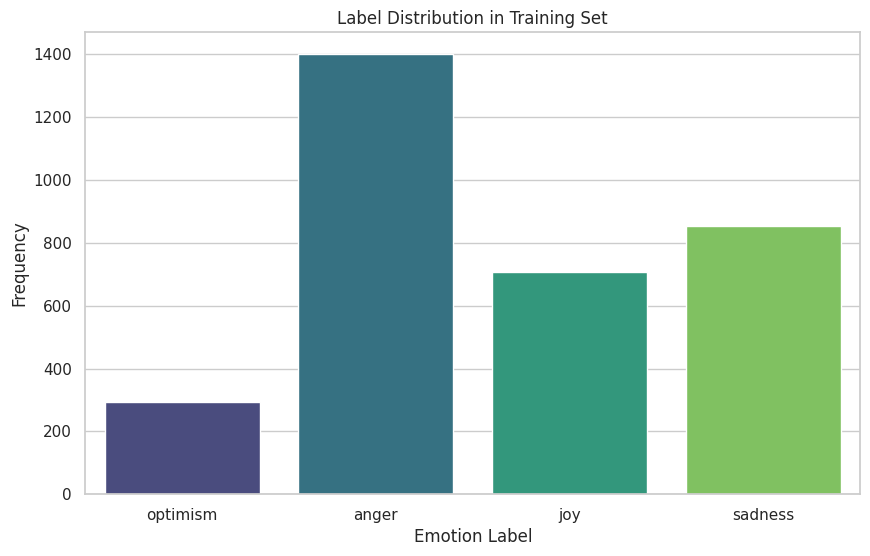

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plots
sns.set(style="whitegrid")

# Analyzing label distribution
print("\nLabel Distribution in Training Set:")
print(train_df['labels'].value_counts(normalize=True))

# Plotting label distribution using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='labels', data=train_df, palette='viridis')
plt.title('Label Distribution in Training Set')
plt.xlabel('Emotion Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


Text Length Statistics:
count    3257.000000
mean       92.373043
std        36.509767
min         7.000000
25%        61.000000
50%        97.000000
75%       127.000000
max       161.000000
Name: text_length, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


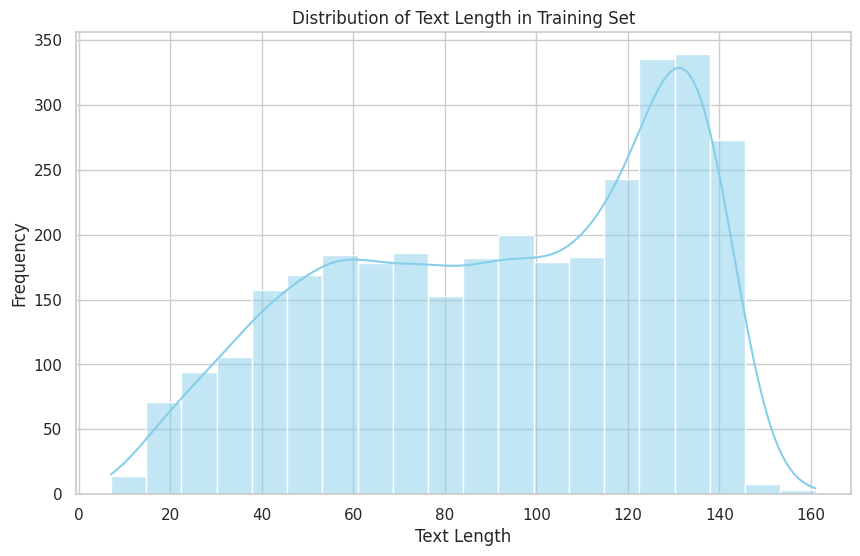

In [35]:
# Set the style of the plots
sns.set(style="whitegrid")

# Analyzing text length
train_df['text_length'] = train_df['tweets'].apply(len)
print("\nText Length Statistics:")
print(train_df['text_length'].describe())

# Histogram for text length using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Text Length in Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

***DATA PRE-PROCESSING***

In [36]:
import re
import string

def preprocess_tweet(text):
    # Convert to lower case
    text = text.lower()
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [37]:
# Apply preprocessing to each tweet
train_df['preprocessed_tweets'] = train_df['tweets'].apply(preprocess_tweet)
test_df['preprocessed_tweets'] = test_df['tweets'].apply(preprocess_tweet)
val_df['preprocessed_tweets'] = val_df['tweets'].apply(preprocess_tweet)

# View the result
print(train_df[['tweets', 'preprocessed_tweets']].head())

                                              tweets  \
0  “Worry is a down payment on a problem you may ...   
1  My roommate: it's okay that we can't spell bec...   
2  No but that's so cute. Atsu was probably shy a...   
3  Rooneys fucking untouchable isn't he? Been fuc...   
4  it's pretty depressing when u hit pan on ur fa...   

                                 preprocessed_tweets  
0  “worry is a down payment on a problem you may ...  
1  my roommate its okay that we cant spell becaus...  
2  no but thats so cute atsu was probably shy abo...  
3  rooneys fucking untouchable isnt he been fucki...  
4  its pretty depressing when u hit pan on ur fav...  


***FILTERING DATASET 1***

In [38]:
# Filter to include only 'joy' and 'sadness'
joy_sadness_df_train = train_df[train_df['labels'].isin(['joy', 'sadness'])]
joy_sadness_df_val = val_df[val_df['labels'].isin(['joy', 'sadness'])]
joy_sadness_df_test = test_df[test_df['labels'].isin(['joy', 'sadness'])]

# Display some of the data to verify
print(joy_sadness_df_train.head())

                                               tweets   labels  text_length  \
2   No but that's so cute. Atsu was probably shy a...      joy           95   
4   it's pretty depressing when u hit pan on ur fa...  sadness           66   
6   Making that yearly transition from excited and...  sadness          114   
7   Tiller and breezy should do a collab album. Ra...      joy           79   
11  #NewYork: Several #Baloch &amp; Indian activis...  sadness          147   

                                  preprocessed_tweets  
2   no but thats so cute atsu was probably shy abo...  
4   its pretty depressing when u hit pan on ur fav...  
6   making that yearly transition from excited and...  
7   tiller and breezy should do a collab album rap...  
11  newyork several baloch amp indian activists ho...  


***TOKENIZING***

In [39]:
# Combine all tweets into a single string and then split into words
raw_text = ' '.join(joy_sadness_df_train['preprocessed_tweets']).split()

# Create a set to deduplicate, then convert back to list to create a vocabulary
vocab = list(set(raw_text))

# Create a dictionary to map each word to a unique index
word_to_ix = {word: i + 2 for i, word in enumerate(vocab)}  # Starting from 2; 0 and 1 are reserved

In [40]:
vocab_size = len(word_to_ix) + 2  # Adding 2 to account for padding and unknown tokens
vocab_size

5365

***ENCODING THE TWEETS WITH THEIR TOKENS***

In [41]:
def encode_tweet(tweet):
    return [word_to_ix.get(word, 1) for word in tweet.split()]  # 1 for unknown words

joy_sadness_df_train['encoded_tweets'] = joy_sadness_df_train['preprocessed_tweets'].apply(encode_tweet)

/tmp/ipykernel_47/2266654036.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joy_sadness_df_train['encoded_tweets'] = joy_sadness_df_train['preprocessed_tweets'].apply(encode_tweet)


***PADDING THE DATASET***

In [42]:
max_len = max(len(tweet) for tweet in joy_sadness_df_train['encoded_tweets'])
joy_sadness_df_train['padded_tweets'] = joy_sadness_df_train['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))

/tmp/ipykernel_47/3941809328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joy_sadness_df_train['padded_tweets'] = joy_sadness_df_train['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))


In [43]:
joy_sadness_df_train.head()

,tweets,labels,text_length,preprocessed_tweets,encoded_tweets,padded_tweets
2,No but that's so cute. Atsu was probably shy a...,joy,95,no but thats so cute atsu was probably shy abo...,"[3995, 2314, 1173, 637, 5019, 4580, 732, 1855,...","[3995, 2314, 1173, 637, 5019, 4580, 732, 1855,..."
4,it's pretty depressing when u hit pan on ur fa...,sadness,66,its pretty depressing when u hit pan on ur fav...,"[1049, 2387, 580, 4020, 2635, 2063, 2490, 5025...","[1049, 2387, 580, 4020, 2635, 2063, 2490, 5025..."
6,Making that yearly transition from excited and...,sadness,114,making that yearly transition from excited and...,"[1271, 2415, 3268, 205, 2117, 5107, 2892, 1232...","[1271, 2415, 3268, 205, 2117, 5107, 2892, 1232..."
7,Tiller and breezy should do a collab album. Ra...,joy,79,tiller and breezy should do a collab album rap...,"[2523, 2892, 2679, 4122, 2007, 317, 5232, 491,...","[2523, 2892, 2679, 4122, 2007, 317, 5232, 491,..."
11,#NewYork: Several #Baloch &amp; Indian activis...,sadness,147,newyork several baloch amp indian activists ho...,"[3618, 3550, 3870, 3209, 2955, 4207, 1480, 484...","[3618, 3550, 3870, 3209, 2955, 4207, 1480, 484..."


In [44]:
# Convert padded tweets to PyTorch tensors
X_train_js = torch.tensor(joy_sadness_df_train['padded_tweets'].tolist())
y_train_js = torch.tensor(joy_sadness_df_train['labels'].apply(lambda x: 1 if x == 'joy' else 0).values)  # Encoding labels as 0 and 1

***CONVERTING THE DATA INTO TENSORS***

In [45]:
# Repeat the same process for validation and test sets
# Note: Make sure to use the same 'word_to_ix' and 'max_len' for consistency
joy_sadness_df_val['encoded_tweets'] = joy_sadness_df_val['preprocessed_tweets'].apply(encode_tweet)
joy_sadness_df_val['padded_tweets'] = joy_sadness_df_val['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))
X_val_js = torch.tensor(joy_sadness_df_val['padded_tweets'].tolist())
y_val_js = torch.tensor(joy_sadness_df_val['labels'].apply(lambda x: 1 if x == 'joy' else 0).values)

joy_sadness_df_test['encoded_tweets'] = joy_sadness_df_test['preprocessed_tweets'].apply(encode_tweet)
joy_sadness_df_test['padded_tweets'] = joy_sadness_df_test['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))
X_test_js = torch.tensor(joy_sadness_df_test['padded_tweets'].tolist())
y_test_js = torch.tensor(joy_sadness_df_test['labels'].apply(lambda x: 1 if x == 'joy' else 0).values)

/tmp/ipykernel_47/3598680512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joy_sadness_df_val['encoded_tweets'] = joy_sadness_df_val['preprocessed_tweets'].apply(encode_tweet)
/tmp/ipykernel_47/3598680512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joy_sadness_df_val['padded_tweets'] = joy_sadness_df_val['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))
/tmp/ipykernel_47/3598680512.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

***CLASS FOR DATALOADER***

In [46]:
from torch.utils.data import Dataset, DataLoader

class TweetDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TweetDataset(X_train_js, y_train_js)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = TweetDataset(X_val_js, y_val_js)
val_loader = DataLoader(val_dataset, batch_size=10)

test_dataset = TweetDataset(X_test_js, y_test_js)
test_loader = DataLoader(test_dataset, batch_size=10)

In [47]:
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

***DEFINING THE CNN CLASS***

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import numpy as np

class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, output_size, activation_fn, dropout_rate, num_filters, kernel_size, stride, pool_size, padding = 0):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Convolutional layer
        self.conv_1 = nn.Conv1d(embed_dim, num_filters, kernel_size=kernel_size, stride=stride)
        self.bn_1 = nn.BatchNorm1d(num_filters)
        self.pool = nn.MaxPool1d(kernel_size=pool_size)
        
        # Calculate the sequence length after convolution and pooling
        seq_len = 33  # Input sequence length
        seq_len = (seq_len - kernel_size + 2 * padding) // stride + 1  # After conv_1 with kernel_size=5, stride=1
        seq_len = (seq_len - pool_size) // pool_size + 1     # After max pooling with kernel_size=2
        
        self.flattened_size = seq_len * num_filters  # Output size after conv_1 * channels
        
        # Fully connected layer
        self.fc1 = nn.Linear(self.flattened_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation_fn = activation_fn
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.activation_fn(self.bn_1(self.conv_1(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(self.fc1(x))
        return x


***SETTING PARAMETERS 1***

In [49]:
embed_dim = 128     # The size of the embedding vector
num_classes = 1     # For binary classification
output_size = 128   # Based on the pooling and convolutional layers
num_filters = 128    # Number of convolutional filters
kernel_size = 5     # Size of the convolutional kernel
stride = 1          # Stride for convolution
pool_size = 2       # Pooling size
dropout_rate = 0.5  # Dropout rate
activation_fn = torch.relu  # Activation function, can also use torch.tanh, etc.

In [50]:
# Instantiate the CNN model with all the parameters
model = CNN(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_classes=num_classes,
    output_size=output_size,  # This should correspond to the expected output size of the conv layers
    activation_fn=activation_fn,
    dropout_rate=dropout_rate,
    num_filters=num_filters,
    kernel_size=kernel_size,
    stride=stride,
    pool_size=pool_size
)

# GPU Acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (embedding): Embedding(5365, 128, padding_idx=0)
  (conv_1): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1792, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [51]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

***TRAIN LOOP FOR DATASET 1***

In [52]:
from tqdm import tqdm

num_epochs = 50
train_losses = []
val_losses = []

min_val_loss = np.Inf
patience = 7  # How many epochs to wait after last time validation loss improved
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Add tqdm progress bar for training
    train_loop = tqdm(train_loader, total=len(train_loader), leave=True)
    for tweets, labels in train_loop:
        
        optimizer.zero_grad()
        
        outputs = model(tweets.to(device))
        
        loss = criterion(outputs, labels.to(device).unsqueeze(1).float())
        loss.backward()
        
        optimizer.step()
        
        total_train_loss += loss.item()
        
        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(train_loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0

    # Add tqdm progress bar for validation
    val_loop = tqdm(val_loader, total=len(val_loader), leave=False)
    with torch.no_grad():
        for tweets, labels in val_loop:
            outputs = model(tweets.to(device))
            loss = criterion(outputs, labels.to(device).unsqueeze(1).float())
            total_val_loss += loss.item()
            val_loop.set_postfix(val_loss=loss.item())    

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Early stopping check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print("Early stopping triggered")
        break


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch 1/50: 100%|██████████| 157/157 [00:00<00:00, 217.13it/s, train_loss=0.542]


Epoch 1/50, Train Loss: 0.8070, Validation Loss: 0.7785


Epoch 2/50: 100%|██████████| 157/157 [00:00<00:00, 199.27it/s, train_loss=0.694]


Epoch 2/50, Train Loss: 0.5913, Validation Loss: 0.7067


Epoch 3/50: 100%|██████████| 157/157 [00:00<00:00, 205.85it/s, train_loss=0.463]


Epoch 3/50, Train Loss: 0.5312, Validation Loss: 0.7063


Epoch 4/50: 100%|██████████| 157/157 [00:00<00:00, 219.60it/s, train_loss=0.693]


Epoch 4/50, Train Loss: 0.4719, Validation Loss: 0.7716


Epoch 5/50: 100%|██████████| 157/157 [00:00<00:00, 219.85it/s, train_loss=0.235]


Epoch 5/50, Train Loss: 0.4490, Validation Loss: 1.0093


Epoch 6/50: 100%|██████████| 157/157 [00:00<00:00, 217.86it/s, train_loss=0.467]


Epoch 6/50, Train Loss: 0.4029, Validation Loss: 0.7377


Epoch 7/50: 100%|██████████| 157/157 [00:00<00:00, 216.16it/s, train_loss=0.231]


Epoch 7/50, Train Loss: 0.4120, Validation Loss: 0.7323


Epoch 8/50: 100%|██████████| 157/157 [00:00<00:00, 220.83it/s, train_loss=0.231]


Epoch 8/50, Train Loss: 0.3867, Validation Loss: 0.7487


Epoch 9/50: 100%|██████████| 157/157 [00:00<00:00, 217.36it/s, train_loss=0.268]


Epoch 9/50, Train Loss: 0.3833, Validation Loss: 0.7528


Epoch 10/50: 100%|██████████| 157/157 [00:00<00:00, 211.18it/s, train_loss=0.233] 


Early stopping triggered


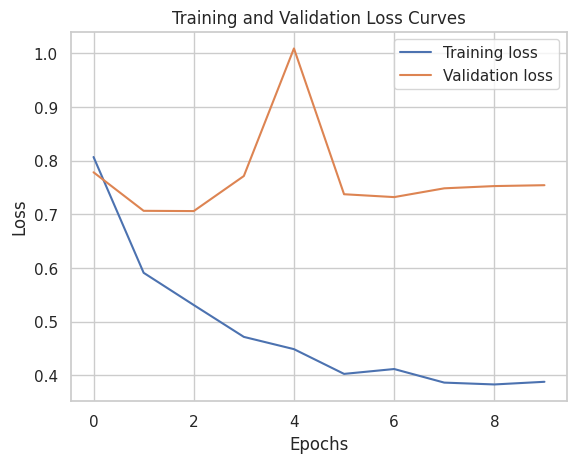

In [53]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

***GRID SEARCH FOR BEST MODEL PARAMETERS***

In [54]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Define hyperparameters to search over
param_grid = {
    'optimizer': [optim.Adam, optim.SGD],
    'learning_rate': [0.0001],
    'dropout_rate': [0.5],
    'num_filters': [64, 128],
    'kernel_size': [3, 5],
    'stride': [1],
    'pool_size': [2, 3],
    'batch_size': [10],
    'activation_fn': [torch.relu, torch.tanh],
    # Add other hyperparameters here
}

# Set up the grid search
grid = ParameterGrid(param_grid)

best_loss = float('inf')
best_params = None

for params in grid:
    # Data loaders with the current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'])
    
    model = CNN(
        vocab_size,
        embed_dim,
        num_classes,
        output_size,
        params['activation_fn'],
        params['dropout_rate'],
        params['num_filters'],
        params['kernel_size'],
        params['stride'],
        params['pool_size']
    ).to(device)
    
    optimizer = params['optimizer'](model.parameters(), lr=params['learning_rate'])
    criterion = nn.BCEWithLogitsLoss()
    
    # Train the model
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for tweets, labels in tqdm(train_loader, total=len(train_loader), leave=True):
            optimizer.zero_grad()
            outputs = model(tweets.to(device))
            loss = criterion(outputs, labels.to(device).unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

    # Evaluate the model
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for tweets, labels in tqdm(val_loader, total=len(val_loader), leave=False):
            outputs = model(tweets.to(device))
            loss = criterion(outputs, labels.to(device).unsqueeze(1).float())
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    
    # Check if this is the best hyperparameter combination so far
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_params = params
        # Optionally save the model
        torch.save(model.state_dict(), f'model_{epoch}.pt')

# Print out the best set of hyperparameters
print(f"Best hyperparameters: {best_params}")
print(f"Best validation loss: {best_loss}")


100%|██████████| 157/157 [00:00<00:00, 543.76it/s]
                                      

Best hyperparameters: {'activation_fn': <built-in method tanh of type object at 0x7b4595992660>, 'batch_size': 10, 'dropout_rate': 0.5, 'kernel_size': 3, 'learning_rate': 0.0001, 'num_filters': 64, 'optimizer': <class 'torch.optim.adam.Adam'>, 'pool_size': 3, 'stride': 1}
Best validation loss: 0.6409143052603069


In [120]:
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'activation_fn': <built-in method tanh of type object at 0x7b4595992660>, 'batch_size': 10, 'dropout_rate': 0.5, 'kernel_size': 3, 'learning_rate': 0.0001, 'num_filters': 64, 'optimizer': <class 'torch.optim.adam.Adam'>, 'pool_size': 3, 'stride': 1}


***TESTING ON DATASET 1 WITH THE BEST MODEL***

In [106]:
best_model

CNN(
  (embedding): Embedding(5365, 128, padding_idx=0)
  (conv_1): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [59]:
best_model = CNN(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_classes=num_classes,
    output_size=output_size,
    activation_fn=best_params['activation_fn'],
    dropout_rate=best_params['dropout_rate'],
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    stride=best_params['stride'],
    pool_size=best_params['pool_size']
).to(device)

# Load the saved state_dict
best_model.load_state_dict(torch.load('model_49.pt'))

# Set the model to evaluation mode
best_model.eval()

# Lists to store true labels and predictions
all_labels = []
all_predictions = []

# No gradient is needed for evaluation
with torch.no_grad():
    for tweets, labels in test_loader:
        tweets, labels = tweets.to(device), labels.to(device)

        # Forward pass
        outputs = best_model(tweets)

        # Convert logits to probabilities using sigmoid
        probabilities = torch.sigmoid(outputs).squeeze()

        # Apply a threshold to convert probabilities to binary predictions
        predictions = (probabilities >= 0.5).long()

        # Store predictions and labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Classification report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=['Sadness', 'Joy']))


              precision    recall  f1-score   support

     Sadness       0.63      0.65      0.64       382
         Joy       0.61      0.59      0.60       358

    accuracy                           0.62       740
   macro avg       0.62      0.62      0.62       740
weighted avg       0.62      0.62      0.62       740



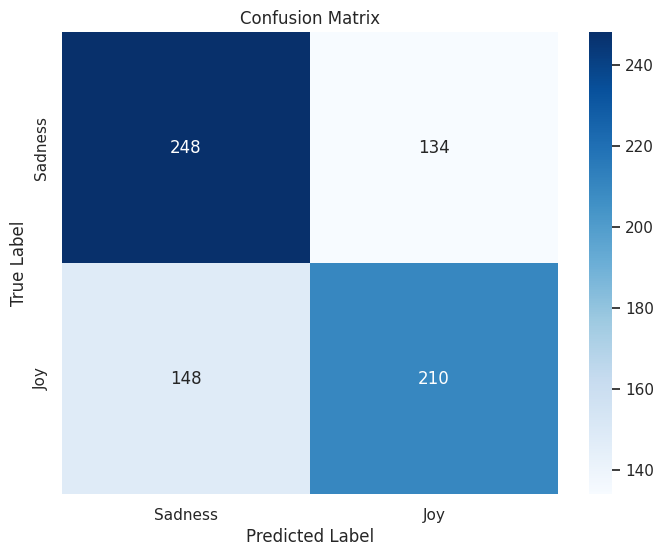

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sadness', 'Joy'], yticklabels=['Sadness', 'Joy'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

***FILTERING DATASET 2***

In [66]:
# Filter to include only 'joy' and 'sadness'
anger_sadness_df_train = train_df[train_df['labels'].isin(['anger', 'sadness'])]
anger_sadness_df_val = val_df[val_df['labels'].isin(['anger', 'sadness'])]
anger_sadness_df_test = test_df[test_df['labels'].isin(['anger', 'sadness'])]

# Display some of the data to verify
print(anger_sadness_df_train.head())

                                              tweets   labels  text_length  \
1  My roommate: it's okay that we can't spell bec...    anger           99   
3  Rooneys fucking untouchable isn't he? Been fuc...    anger          103   
4  it's pretty depressing when u hit pan on ur fa...  sadness           66   
5  @user but your pussy was weak from what I hear...    anger          118   
6  Making that yearly transition from excited and...  sadness          114   

                                 preprocessed_tweets  
1  my roommate its okay that we cant spell becaus...  
3  rooneys fucking untouchable isnt he been fucki...  
4  its pretty depressing when u hit pan on ur fav...  
5   but your pussy was weak from what i heard so ...  
6  making that yearly transition from excited and...  


***ENCODE TWEETS WITH THEIR TOKENS***

In [70]:
anger_sadness_df_train['encoded_tweets'] = anger_sadness_df_train['preprocessed_tweets'].apply(encode_tweet)

/tmp/ipykernel_47/4204077456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anger_sadness_df_train['encoded_tweets'] = anger_sadness_df_train['preprocessed_tweets'].apply(encode_tweet)


In [71]:
max_len = max(len(tweet) for tweet in anger_sadness_df_train['encoded_tweets'])
anger_sadness_df_train['padded_tweets'] = anger_sadness_df_train['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))

/tmp/ipykernel_47/3691852828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anger_sadness_df_train['padded_tweets'] = anger_sadness_df_train['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))


***CONVERT DATA INTO TENSORS***

In [72]:
# Convert padded tweets to PyTorch tensors
X_train_as = torch.tensor(anger_sadness_df_train['padded_tweets'].tolist())
y_train_as = torch.tensor(anger_sadness_df_train['labels'].apply(lambda x: 1 if x == 'anger' else 0).values)  # Encoding labels as 0 and 1

In [73]:
# Repeat the same process for validation and test sets
# Note: Make sure to use the same 'word_to_ix' and 'max_len' for consistency
anger_sadness_df_val['encoded_tweets'] = anger_sadness_df_val['preprocessed_tweets'].apply(encode_tweet)
anger_sadness_df_val['padded_tweets'] = anger_sadness_df_val['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))
X_val_as = torch.tensor(anger_sadness_df_val['padded_tweets'].tolist())
y_val_as = torch.tensor(anger_sadness_df_val['labels'].apply(lambda x: 1 if x == 'anger' else 0).values)

anger_sadness_df_test['encoded_tweets'] = anger_sadness_df_test['preprocessed_tweets'].apply(encode_tweet)
anger_sadness_df_test['padded_tweets'] = anger_sadness_df_test['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))
X_test_as = torch.tensor(anger_sadness_df_test['padded_tweets'].tolist())
y_test_as = torch.tensor(anger_sadness_df_test['labels'].apply(lambda x: 1 if x == 'anger' else 0).values)

/tmp/ipykernel_47/993213388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anger_sadness_df_val['encoded_tweets'] = anger_sadness_df_val['preprocessed_tweets'].apply(encode_tweet)
/tmp/ipykernel_47/993213388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anger_sadness_df_val['padded_tweets'] = anger_sadness_df_val['encoded_tweets'].apply(lambda x: x + [0] * (max_len - len(x)))
/tmp/ipykernel_47/993213388.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

***LOADING THE DATA INTO DATALOADERS***

In [74]:
train_dataset = TweetDataset(X_train_as, y_train_as)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = TweetDataset(X_val_as, y_val_as)
val_loader = DataLoader(val_dataset, batch_size=10)

test_dataset = TweetDataset(X_test_as, y_test_as)
test_loader = DataLoader(test_dataset, batch_size=10)

***USING BEST MODEL FROM DATASET 1 EXPERIMENT TO TRAIN ON DATASET 2***

In [114]:
best_model = CNN(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_classes=num_classes,
    output_size=output_size,
    activation_fn=best_params['activation_fn'],
    dropout_rate=best_params['dropout_rate'],
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    stride=best_params['stride'],
    pool_size=best_params['pool_size']
).to(device)

In [115]:
best_model

CNN(
  (embedding): Embedding(5365, 128, padding_idx=0)
  (conv_1): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [116]:
from tqdm import tqdm

num_epochs = 50
train_losses = []
val_losses = []

min_val_loss = np.Inf
patience = 7  # How many epochs to wait after last time validation loss improved
patience_counter = 0

for epoch in range(num_epochs):
    best_model.train()
    total_train_loss = 0

    # Add tqdm progress bar for training
    train_loop = tqdm(train_loader, total=len(train_loader), leave=True)
    for tweets, labels in train_loop:
        
        optimizer.zero_grad()
        
        outputs = best_model(tweets.to(device))
        
        loss = criterion(outputs, labels.to(device).unsqueeze(1).float())
        loss.backward()
        
        optimizer.step()
        
        total_train_loss += loss.item()
        
        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(train_loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    best_model.eval()
    total_val_loss = 0

    # Add tqdm progress bar for validation
    val_loop = tqdm(val_loader, total=len(val_loader), leave=False)
    with torch.no_grad():
        for tweets, labels in val_loop:
            outputs = best_model(tweets.to(device))
            loss = criterion(outputs, labels.to(device).unsqueeze(1).float())
            total_val_loss += loss.item()
            val_loop.set_postfix(val_loss=loss.item())    

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Early stopping check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print("Early stopping triggered")
        break


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch 1/50: 100%|██████████| 226/226 [00:00<00:00, 247.29it/s, train_loss=0.573]


Epoch 1/50, Train Loss: 0.6984, Validation Loss: 0.6921


Epoch 2/50: 100%|██████████| 226/226 [00:00<00:00, 241.08it/s, train_loss=0.75] 


Epoch 2/50, Train Loss: 0.7015, Validation Loss: 0.6898


Epoch 3/50: 100%|██████████| 226/226 [00:00<00:00, 245.51it/s, train_loss=0.684]


Epoch 3/50, Train Loss: 0.6994, Validation Loss: 0.6896


Epoch 4/50: 100%|██████████| 226/226 [00:00<00:00, 236.06it/s, train_loss=0.64] 


Epoch 4/50, Train Loss: 0.6991, Validation Loss: 0.6914


Epoch 5/50: 100%|██████████| 226/226 [00:00<00:00, 245.02it/s, train_loss=0.71] 


Epoch 5/50, Train Loss: 0.7028, Validation Loss: 0.6879


Epoch 6/50: 100%|██████████| 226/226 [00:00<00:00, 235.22it/s, train_loss=0.674]


Epoch 6/50, Train Loss: 0.7028, Validation Loss: 0.6885


Epoch 7/50: 100%|██████████| 226/226 [00:00<00:00, 239.53it/s, train_loss=0.826]


Epoch 7/50, Train Loss: 0.7041, Validation Loss: 0.6890


Epoch 8/50: 100%|██████████| 226/226 [00:00<00:00, 243.59it/s, train_loss=0.73] 


Epoch 8/50, Train Loss: 0.7039, Validation Loss: 0.6884


Epoch 9/50: 100%|██████████| 226/226 [00:00<00:00, 246.42it/s, train_loss=0.637]


Epoch 9/50, Train Loss: 0.7002, Validation Loss: 0.6896


Epoch 10/50: 100%|██████████| 226/226 [00:00<00:00, 249.71it/s, train_loss=0.757]


Epoch 10/50, Train Loss: 0.6994, Validation Loss: 0.6905


Epoch 11/50: 100%|██████████| 226/226 [00:00<00:00, 230.54it/s, train_loss=0.749]


Epoch 11/50, Train Loss: 0.7035, Validation Loss: 0.6885


Epoch 12/50: 100%|██████████| 226/226 [00:00<00:00, 238.10it/s, train_loss=0.739]
                                                      

Early stopping triggered


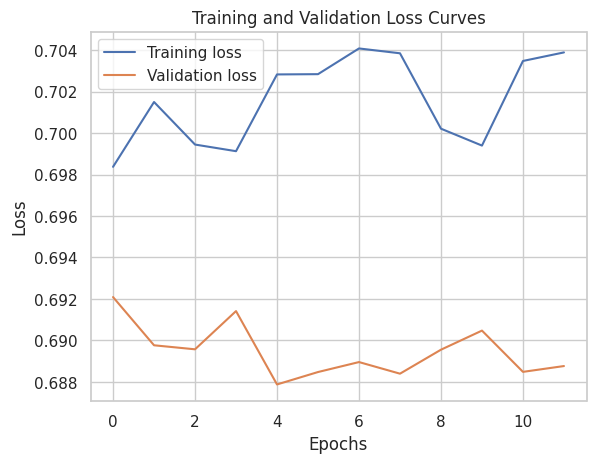

In [117]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

***TESTING ON DATASET 2***

In [118]:
# Lists to store true labels and predictions
all_labels = []
all_predictions = []

# No gradient is needed for evaluation
with torch.no_grad():
    for tweets, labels in test_loader:
        tweets, labels = tweets.to(device), labels.to(device)

        # Forward pass
        outputs = best_model(tweets)

        # Convert logits to probabilities using sigmoid
        probabilities = torch.sigmoid(outputs).squeeze()

        # Apply a threshold to convert probabilities to binary predictions
        predictions = (probabilities >= 0.5).long()

        # Store predictions and labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Classification report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=['Sadness', 'Anger']))

              precision    recall  f1-score   support

     Sadness       0.43      0.56      0.49       382
       Anger       0.62      0.48      0.54       558

    accuracy                           0.51       940
   macro avg       0.52      0.52      0.51       940
weighted avg       0.54      0.51      0.52       940



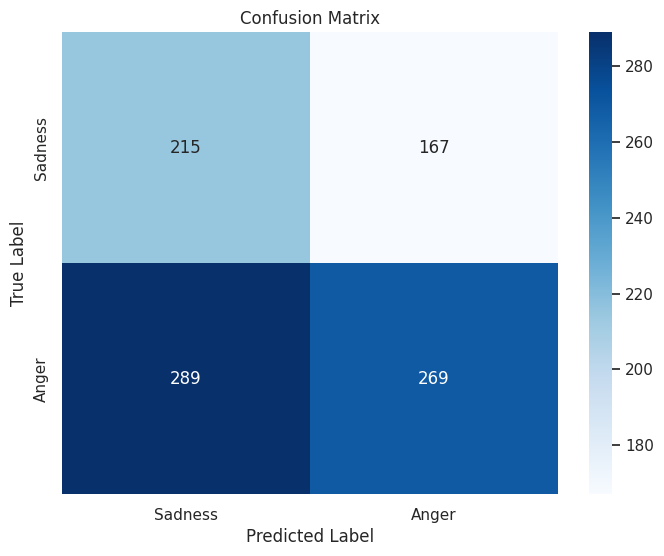

In [119]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sadness', 'Anger'], yticklabels=['Sadness', 'Anger'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()